In [1]:
import tensorflow as tf
import numpy as np
from keras.layers import Dense,Conv2D,BatchNormalization,Conv2DTranspose,Add,MaxPooling2D,GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Model,Input
import matplotlib.pyplot as plt
from google.colab import drive
from keras.preprocessing.image import load_img,img_to_array
import os
import matplotlib.pyplot as pyplot
from keras.initializers import RandomNormal

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/CycleGan/anime.zip -d /content/sample_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/images/62764_2019.jpg  
  inflating: /content/sample_data/images/62765_2019.jpg  
  inflating: /content/sample_data/images/62766_2019.jpg  
  inflating: /content/sample_data/images/62767_2019.jpg  
  inflating: /content/sample_data/images/62768_2019.jpg  
  inflating: /content/sample_data/images/62769_2019.jpg  
  inflating: /content/sample_data/images/6276_2003.jpg  
  inflating: /content/sample_data/images/62770_2019.jpg  
  inflating: /content/sample_data/images/62771_2019.jpg  
  inflating: /content/sample_data/images/62772_2019.jpg  
  inflating: /content/sample_data/images/62773_2019.jpg  
  inflating: /content/sample_data/images/62774_2019.jpg  
  inflating: /content/sample_data/images/62775_2019.jpg  
  inflating: /content/sample_data/images/62776_2019.jpg  
  inflating: /content/sample_data/images/62777_2019.jpg  
  inflating: /content/sample_data/images/62778_2019.jpg  
  inflating: /content/

In [ ]:
!unzip /content/drive/MyDrive/CycleGan/human.zip -d /content/sample_data

In [5]:
path = '/content/sample_data'

In [47]:
def RealData(batch_size,cat='anime'):
  random = np.random.randint(0,9780,batch_size)
  generatedData = []
  for i in np.array(os.listdir(os.path.join(path,cat)))[random]:
    filename = os.path.join(os.path.join(path,cat),i)
    img = load_img(filename,target_size=(64,64))
    imgPixel = img_to_array(img)/255
    generatedData.append(imgPixel)
  return np.asarray(generatedData)

In [48]:
def FakeData(batch_size,model,data):
  X = model.predict(data)
  return X

In [49]:
def discriminator(image_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)
  inputs = Input(shape=image_shape)
  x = Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu', kernel_initializer=init)(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256,kernel_size=(3,3),strides=(2,2),padding='same',activation='relu', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(64,activation='relu', kernel_initializer=init)(x)
  x = Dropout(0.4)(x)
  outputs = Dense(1,activation='sigmoid')(x)

  model = Model(inputs,outputs)
  model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy')
  return model

In [50]:
def resnet(n_filters,input_layer):
  # weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same',activation='relu', kernel_initializer=init)(input_layer)
	g = BatchNormalization()(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = BatchNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Add()([g, input_layer])
	return g

In [51]:
def generator(image_shape):
  init = RandomNormal(stddev=0.02)
  inputs = Input(shape=image_shape)
  x = Conv2D(64,kernel_size=(3,3),padding='same',activation='relu', kernel_initializer=init)(inputs)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128,kernel_size=(3,3),padding='same',activation='relu', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256,kernel_size=(3,3),padding='same',activation='relu', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  for _ in range(20):
	  x = resnet(256, x)
  x = Conv2DTranspose(64,kernel_size=(3,3),strides=(2,2),padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(128,kernel_size=(3,3),strides=(2,2),padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(128,kernel_size=(3,3),strides=(2,2),padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(3,kernel_size=(3,3),strides=(1,1),padding='same',activation='sigmoid', kernel_initializer=init)(x)
  model = Model(inputs,x)
  return model

In [52]:
def compositeNetwork(gen_model1,d_model,gen_model2,image_shape):
  gen_model1.trainable = True #pelajari generator saja
  gen_model1.trainable = False
  d_model.trainable = False

  
  inputDomain1 = Input(shape=image_shape)
  inputDomain2 = Input(shape=image_shape)

  #adversial
  aModel = gen_model1(inputDomain1)
  aoutput = d_model(aModel)

  # identity
  ioutput = gen_model1(inputDomain2)

  #forward
  foutput = gen_model2(aModel)

  #backward
  bModel = gen_model2(inputDomain2)
  boutput = gen_model1(bModel)

  model = Model([inputDomain1,inputDomain2],[aoutput,ioutput,foutput,boutput])
  model.compile(optimizer=Adam(learning_rate=0.02),loss=['binary_crossentropy','mse','mse','mse'],loss_weights=[1,5,10,10])
  return model

In [53]:
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
def summarize_performance(step, g_model, trainX, name, batch=5):
    # select a sample of input images
    X_in, _ = RealData(batch,trainX)
    # generate translated images
    X_out, _ = FakeData(batch,g_model,X_in)
    # plot real images
    for i in range(batch):
        pyplot.subplot(2, batch, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(batch):
        pyplot.subplot(2, batch, 1 + batch + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [178]:
def train(discriminatorA,discriminatorB,generatorB2A,generatorA2B,CModelB2A,CModelA2B):
  step = 100
  batch = 10
  for j in range(step):
    #a = human , b = anime
    XRealA,XRealB,YRealA,YRealB = (RealData(batch,cat='human'),
                                    RealData(batch,cat='anime'),
                                    np.ones(batch).reshape(-1,1),
                                    np.ones(batch).reshape(-1,1)
                                    )
    
    XFakeA,XFakeB,YFakeA,YFakeB = (FakeData(batch,generatorB2A,XRealB),
                                    FakeData(batch,generatorA2B,XRealA),
                                    np.zeros(batch).reshape(-1,1),
                                    np.zeros(batch).reshape(-1,1)
                                    )
    cAModel,_,_,_,_ = CModelB2A.train_on_batch([XRealB,XRealA],[YRealA,XRealA,XRealB,XRealA])
    cBModel,_,_,_,_ = CModelA2B.train_on_batch([XRealA,XRealB],[YRealB,XRealB,XRealA,XRealB])
    XA,YA = np.vstack((XRealA,XFakeA)), np.vstack((YRealA,YFakeA))
    XB,YB = np.vstack((XRealB,XFakeB)), np.vstack((YRealB,YFakeB))
    dAloss = discriminatorA.train_on_batch(XA,YA)
    dBloss = discriminatorB.train_on_batch(XB,YB)
    print('>%d, dA[%.3f] dB[%.3f] g[%.3f,%.3f]' % (j+1, dAloss,dBloss,cAModel,cBModel))
    if j==99:
      filename1 = 'g_model_AtoB.h5'
      generatorA2B.save(filename1)
      filename2 = 'g_model_BtoA.h5'
      generatorB2A.save(filename2)
    # evaluate the model performance every so often
    # if (i+1) % (bat_per_epo * 1) == 0:
    #   # plot A->B translation
    #   summarize_performance(i, generatorA2B, trainA, 'AtoB')
    #   # plot B->A translation
    #   summarize_performance(i, generatorB2A, trainB, 'BtoA')
    # if (i+1) % (bat_per_epo * 5) == 0:
    #   # save the models
    #   save_models(i, generatorA2B, generatorB2A)

In [133]:
discriminatorA,discriminatorB = discriminator(image_shape=(64,64,3)),discriminator(image_shape=(64,64,3))
generatorA, generatorB = generator(image_shape=(64,64,3)),generator(image_shape=(64,64,3))
cModelA2B,cModelB2A = compositeNetwork(generatorB,discriminatorB,generatorA,image_shape=(64,64,3)),compositeNetwork(generatorA,discriminatorA,generatorB,image_shape=(64,64,3))

In [288]:
train(discriminatorA, discriminatorB, generatorA, generatorB, cModelB2A, cModelA2B)

>1, dA[0.000] dB[0.000] g[4.375,47.835]
>2, dA[0.000] dB[0.000] g[2.173,39.929]
>3, dA[0.000] dB[0.000] g[2.974,42.155]
>4, dA[0.002] dB[0.000] g[2.171,40.682]
>5, dA[0.001] dB[0.000] g[3.760,40.603]
>6, dA[0.000] dB[0.000] g[5.938,37.044]
>7, dA[0.005] dB[0.000] g[3.058,37.632]
>8, dA[0.004] dB[0.000] g[2.945,42.719]
>9, dA[0.000] dB[0.000] g[3.691,44.114]
>10, dA[0.000] dB[0.000] g[2.418,41.045]
>11, dA[0.001] dB[0.000] g[2.331,39.533]
>12, dA[0.001] dB[0.000] g[3.120,43.030]
>13, dA[0.000] dB[0.000] g[6.355,42.482]
>14, dA[0.000] dB[0.000] g[6.708,43.261]
>15, dA[0.001] dB[0.000] g[2.617,42.063]
>16, dA[0.000] dB[0.000] g[4.647,42.242]
>17, dA[0.000] dB[0.000] g[4.672,37.881]
>18, dA[0.010] dB[0.000] g[4.310,39.237]
>19, dA[0.000] dB[0.000] g[3.453,37.760]
>20, dA[0.006] dB[0.000] g[6.580,38.423]
>21, dA[0.000] dB[0.000] g[8.558,41.161]
>22, dA[0.000] dB[0.000] g[8.278,41.110]
>23, dA[0.000] dB[0.000] g[14.192,41.855]
>24, dA[0.000] dB[0.000] g[14.380,40.723]
>25, dA[0.690] dB[0.000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [57]:
import cv2

In [58]:
from google.colab.patches import cv2_imshow

In [289]:
a = RealData(1,cat='anime')

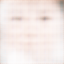

In [290]:
cv2_imshow(cv2.cvtColor(generatorA.predict(a)[0]*255,cv2.COLOR_RGB2BGR))

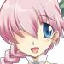

In [291]:
cv2_imshow(cv2.cvtColor(a[0]*255,cv2.COLOR_RGB2BGR))

In [297]:
a = RealData(1,cat='anime')

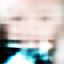

In [298]:
cv2_imshow(cv2.cvtColor(generatorA.predict(a)[0]*255,cv2.COLOR_RGB2BGR))

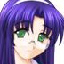

In [299]:
cv2_imshow(cv2.cvtColor(a[0]*255,cv2.COLOR_RGB2BGR))

In [309]:
a = RealData(1,cat='anime')

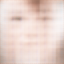

In [310]:
cv2_imshow(cv2.cvtColor(generatorA.predict(a)[0]*255,cv2.COLOR_RGB2BGR))

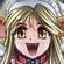

In [311]:
cv2_imshow(cv2.cvtColor(a[0]*255,cv2.COLOR_RGB2BGR))